In [1]:
%matplotlib inline  
import numpy as np
import itertools

from fem1d_classes import *
from math import *
import matplotlib.pyplot as plt
import hierarchical_basis_helper as hier
from functools import reduce
from scipy.linalg import block_diag


  The PDE is defined for 0 < x < 1:
      -u'' = f
    with right hand side
      f(x) = -(exact(x)'')
    and boundary conditions
      u(0) = exact(0),
      u(1) = exact(1).

    For the exact solution:
      exact(x) = x * ( 1 - x ) * exp ( x )
    the boundary conditions are
      u(0) = 0.0,
      u(1) = 0.0
    and the right hand side is:
      f(x) = x * ( x + 3 ) * exp ( x )


In [2]:
def plot_matrix(A):
    #plot matrices
    cmap = plt.cm.get_cmap('PiYG', 11)    # 11 discrete colors
    plt.imshow(A,cmap=cmap,interpolation='none')
    plt.colorbar()
    plt.show()

In [3]:
def FEM_system(level, rhsfn):
    #
    #  Set a mesh of N=2**(level) elements or 2**level+1 nodes in [ xleft, xright ].
    #

    xleft = 0.0
    xright = 1.0
    N  = 2**(level)
    
   
    mesh = Mesh ( N, xleft, xright )
    #
    #  Define the shape functions associated with any element.
    #
    sfns = Shapefns ( )
    #
    #  The mesh and shape functions define the function space V.
    #
    V = FunctionSpace ( mesh, sfns )
    #
    #  Get the coordinates of the degrees of freedom.
    #  Because we use quadratic Lagrange elements, there are 2*N+1 of them.
    #
    x = V.dofpts()
    #
    #  Evaluate the right hand side of the PDE at each node.
    #
    rhs = rhsfn ( x )
    #
    #  Compute b, the right hand side of the finite element system.
    #
    b = V.int_phi ( rhs )
    #
    #  Compute A, the stiffness matrix.
    #
    A = V.int_phi_phi ( derivative = [ True, True ] )
   
    return A, b, x
    

In [4]:
def BoundaryCondition(A,b,exactfn,x):
    #
    #  Modify the linear system to enforce the left boundary condition.
    #
    exact = exactfn ( x )
    A[0,0] = 1.0
    A[0,1:] = 0.0
    b[0] = exact[0]

    #
    #  Modify the linear system to enforce the right boundary condition.
    #
    A[-1,-1] = 1.0
    A[-1,0:-1] = 0.0
    b[-1] = exact[-1]
    return A,b
    

In [5]:
level = 4
rhsfn = lambda x: x*(x+3)*e**x
exactfn = lambda x: x*(1-x)*e**x

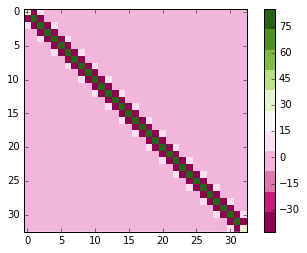

In [6]:
Aorig,b,x = FEM_system(level, rhsfn)
#Aorig,b = BoundaryCondition(Aorig,b,exactfn,x)
plot_matrix(Aorig)

(33, 17)


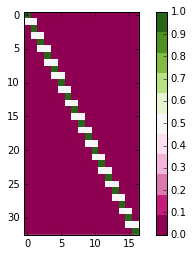

In [7]:
Pmat = hier.create_Pmat(level)  
print(Pmat.shape)
plot_matrix(Pmat)

In [8]:
def getAjj(level, rhsfn, exactfn):
    A11,b1,x = FEM_system(level, rhsfn)
    A11,b1 = BoundaryCondition(A11,b1,exactfn,x)
    return A11, b1
    

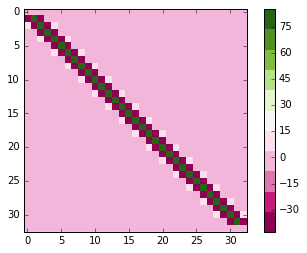

In [9]:
A11,b1 = getAjj(level, rhsfn, exactfn)
plot_matrix(A11)

In [10]:
def get_next_A(A11,b1, level, rhsfn, exactfn):
    """
    Given A11 mat from previous level, and next level find next A matrix
    """
    Av, bv = getAjj(level, rhsfn, exactfn)
    Add = Av 
    Av_list=[]
    bv_list=[bv]
    alist = np.arange(level,0,-1)
    for idx, i in enumerate(alist): 
        Pmat = hier.create_Pmat(i)  # order is P21,P32, ...
        Av = np.dot(Pmat.T,Av)        
        Av_list.append(Av)
        bv = np.dot(Pmat.T,bv)
        bv_list.append(bv)

    Avv = list(reversed(Av_list))  
    Ahh = [Av.T for Av in Avv]
    Avertical = np.vstack(Avv)

    Ahorizontal = np.hstack(Ahh)
    A22 = np.array(np.bmat([[A11, Avertical], [Ahorizontal,Add]]))
    b2 = np.array(list(itertools.chain(*bv_list)))
    return A22, b2
        

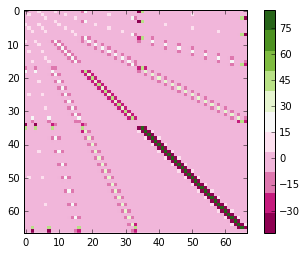

In [11]:
def get_multilevel_Ab(maxlevel, rhsfn, exactfn):
    A11,b1 = getAjj(0, rhsfn, exactfn)
    for level in np.arange(1,maxlevel):
        A11, b1 = get_next_A(A11,b1, level, rhsfn, exactfn)
    return A11, b1
A,b = get_multilevel_Ab(5, rhsfn, exactfn)
plot_matrix(A)    

In [12]:
Ajj,bj = getAjj(1, rhsfn, exactfn)
Ajj.shape

(5, 5)

In [13]:
def append_system(U, n):
    return block_diag(U,np.eye(n))
def extend_system(x1,n):
    x1list = [x1,np.zeros(n)]
    x1 = np.array(list(itertools.chain(*x1list)))
    return x1
def get_sv(A11,sthresh=1e-1):
    U1, s1, V1 = np.linalg.svd(A11)
    U1 = U1[:,s1>sthresh]
    V1 = V1[:,s1>sthresh]
    return U1,V1
def project_system(U1,V1,A11,b1):
    return np.dot(U1.T,np.dot(A11,V1)), np.dot(U1.T,b1)
    

In [16]:
thresh=1e-1
def get_residual(maxlevel, rhsfn, exactfn):
    A11,b1 = get_multilevel_Ab(0, rhsfn, exactfn)     
    U1,V1 = get_sv(A11)
    A11,b1 = project_system(U1,V1,A11,b1)
    print('coarse scale system '+ str(A11.shape))
    x1 = np.squeeze(np.linalg.solve(A11, b1))
    print('x1 tilde ' + str(x1.shape))

    Ulist = [U1]
    Vlist = [V1]

    for level in np.arange(2,maxlevel):
        Ajj,bj = getAjj(level-1, rhsfn, exactfn)
        n=len(Ajj)
        Ulist = [append_system(U,n) for U in Ulist]
        U1 = reduce(lambda x, y: np.dot(x,y), Ulist)
        
        Vlist = [append_system(U,n) for U in Vlist]
        V1 = reduce(lambda x, y: np.dot(x,y), Vlist)
        
        x1 = extend_system(x1,n)
        print('x_(j) tilde extended with zeros '+ str(x1.shape ) )
        A11,b1 = get_multilevel_Ab(level, rhsfn, exactfn)
        print('projected extended system ' + str(A11.shape))
        print('matrices used for projection: '+ str(U1.shape))
        print(V1.shape)
        A11,b1 = project_system(U1,V1,A11,b1)
        res = np.dot(A11,x1) - b1

        if res.all()>thresh:
            U1,V1 = get_sv(A11)
            Ulist.append(U1)
            Vlist.append(V1)
            A11,b1 = project_system(U1,V1,A11,b1)
            x1 = np.squeeze(np.linalg.solve(A11, b1))
            print('solution of next level projected system x_(j+1) tilde' + str(x1.shape))
        else:
            print('breaking at level: ' + level)
            break
    return res, Ulist, Vlist

In [17]:
res, Ulist, Vlist = get_residual(6, rhsfn, exactfn)
res

coarse scale system (3, 3)
x1 tilde (3,)
x_(j) tilde extended with zeros (8,)
projected extended system (8, 8)
matrices used for projection: (8, 8)
(8, 8)
solution of next level projected system x_(j+1) tilde(7,)
x_(j) tilde extended with zeros (16,)
projected extended system (17, 17)
matrices used for projection: (17, 16)
(17, 16)
solution of next level projected system x_(j+1) tilde(15,)
x_(j) tilde extended with zeros (32,)
projected extended system (34, 34)
matrices used for projection: (34, 32)
(34, 32)
solution of next level projected system x_(j+1) tilde(29,)
x_(j) tilde extended with zeros (62,)
projected extended system (67, 67)
matrices used for projection: (67, 62)
(67, 62)
solution of next level projected system x_(j+1) tilde(57,)


array([ -3.23090578e-01,  -8.59362856e-01,  -3.76647807e-01,
        -5.77043402e-01,  -5.68352363e-01,  -2.06272029e-01,
         1.24627186e-01,   8.25551336e-02,   2.08753869e-01,
        -5.23172678e-01,  -1.54174592e-01,   1.11549454e-01,
         3.19374136e-02,   2.38968983e-01,  -4.89764602e-01,
        -3.11677240e-01,   1.81429737e-02,   1.25729009e-01,
         6.93685857e-01,  -1.47591487e+00,   5.20546316e-01,
         7.34390344e-01,  -4.23290207e-01,  -8.41236701e-01,
        -8.81163534e-01,   1.30768503e-01,  -7.56000494e-01,
         5.36705389e-01,   3.85347839e-01,   2.79189192e+01,
        -3.29920145e+01,   3.02297961e+00,  -6.54608102e-02,
        -5.52303228e-02,  -1.15410845e-01,  -8.22314171e-02,
        -1.80723104e-01,   9.95516267e-03,  -2.65031859e-01,
        -1.07145966e-01,  -3.72723935e-01,   9.16955369e-02,
        -5.09082286e-01,  -1.38568089e-01,  -2.11115638e-01,
        -1.11876497e-01,  -5.69716105e-02,  -5.02750271e-01,
        -2.32737057e-01,

In [18]:
maxlevel=5
A11, b1 = get_multilevel_Ab(maxlevel, rhsfn, exactfn)

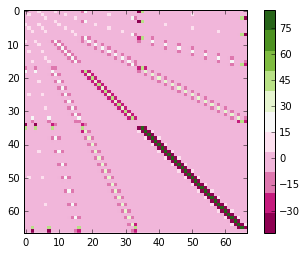

In [19]:
plot_matrix(A11)